# Cross Section for Many Lines using MODIT

Update: August 13/2021, Hajime Kawahara

We demonstarte the Modified Discrete Integral Transform (MODIT), which is the modified version of DIT for exojax. MODIT uses the evenly-spaced logarithm grid (ESLOG) as a wavenumber dimension. MODIT takes advantage especially for the case that the number of the molecular line is large (typically > 10,000). We here compare the results by MODIT with the direct computation (LPF).

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import jax.numpy as jnp
plt.style.use('bmh')

In [2]:
from exojax.spec.hitran import SijT, doppler_sigma, gamma_hitran, gamma_natural
from exojax.spec import moldb

# Setting wavenumber bins and loading HITRAN database
nus=np.logspace(np.log10(1900.0),np.log10(2300.0),350000,dtype=np.float64)
R=(len(nus)-1)/np.log(nus[-1]/nus[0]) #resolution

mdbCO=moldb.MdbHit('05_hit12.par',nus)
# set T, P and partition function
Mmol=28.01 # molecular weight
Tfix=1000.0 # we assume T=1000K
Pfix=1.e-3 # we compute P=1.e-3 bar
Ppart=Pfix #partial pressure of CO. here we assume a 100% CO atmosphere.
qt=mdbCO.Qr_layer_HAPI([Tfix])[0]

# compute Sij, gamma_L, sigmaD
Sij=SijT(Tfix,mdbCO.logsij0,mdbCO.nu_lines,mdbCO.elower,qt)
gammaL = gamma_hitran(Pfix,Tfix, Ppart, mdbCO.n_air, \
                      mdbCO.gamma_air, mdbCO.gamma_self) \
+ gamma_natural(mdbCO.A)

https://hitran.org/hitemp/data/bzip2format/05_hit12.par
HITEMP download failed


MODIT uses the normalized quantities by wavenumber/R, where R is the spectral resolution. In this case, the normalized Doppler width (nsigmaD) is common for the same isotope. Then, we use a 2D DIT grid with the normalized gammaL and q = R log(nu).

In [3]:
from exojax.spec.hitran import normalized_doppler_sigma
dv_lines=mdbCO.nu_lines/R
nsigmaD=normalized_doppler_sigma(Tfix,Mmol,R)
ngammaL=gammaL/dv_lines

MODIT uses a grid of ngammaL, and wavenumber. ditgrid makes a 1D grid for ngamma.

In [11]:
from exojax.spec.modit import ditgrid
ngammaL_grid=ditgrid(ngammaL)

# we can change the resolution using res option
#ngammaL_grid=set_ditgrid(ngammaL,res=0.1)

Text(0, 0.5, 'normalized gammaL')

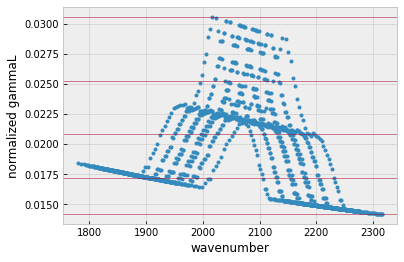

In [12]:
#show the grids
plt.plot(mdbCO.nu_lines,ngammaL,".")
for i in ngammaL_grid:
    plt.axhline(i,lw=1,alpha=0.5,color="C1")
plt.xlabel("wavenumber")
plt.ylabel("normalized gammaL")

We need to precompute the contribution for wavenumber and pmarray. These can be computed using init_dit. 

In [6]:
from exojax.spec import initspec 
cnu,indexnu,R,pmarray=initspec.init_modit(mdbCO.nu_lines,nus)

Let's compute the cross section!

In [7]:
from exojax.spec.modit import xsvector
xs=xsvector(cnu,indexnu,R,pmarray,nsigmaD,ngammaL,Sij,nus,ngammaL_grid)

Also, we here try the direct computation using LPF for the comparison purpose

In [8]:
from exojax.spec import xsection
sigmaD=doppler_sigma(mdbCO.nu_lines,Tfix,Mmol)
xsv=xsection(nus,mdbCO.nu_lines,sigmaD,gammaL,Sij,memory_size=30)

100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 33.26it/s]


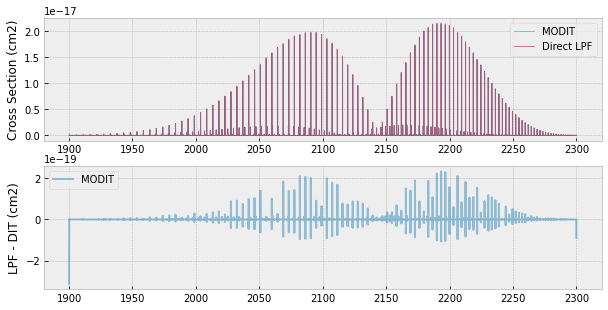

In [9]:
fig=plt.figure(figsize=(10,5))
ax=fig.add_subplot(211)
plt.plot(nus,xs,lw=1,alpha=0.5,label="MODIT")
plt.plot(nus,xsv,lw=1,alpha=0.5,label="Direct LPF")
plt.legend(loc="upper right")
plt.ylabel("Cross Section (cm2)")
ax=fig.add_subplot(212)
plt.plot(nus,xsv-xs,lw=2,alpha=0.5,label="MODIT")
plt.ylabel("LPF - DIT (cm2)")
plt.legend(loc="upper left")
plt.show()

There is about 1 % deviation between LPF and MODIT. 

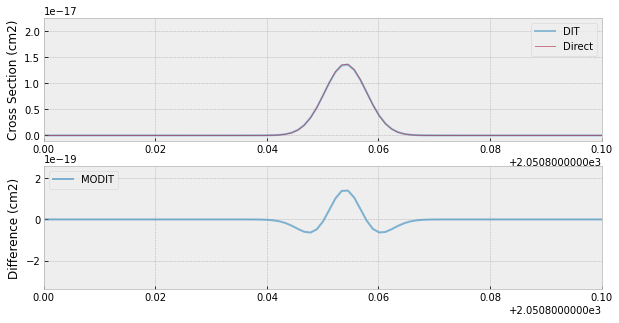

In [10]:
fig=plt.figure(figsize=(10,5))
ax=fig.add_subplot(211)
plt.plot(nus,xs,lw=2,alpha=0.5,label="DIT")
plt.plot(nus,xsv,lw=1,alpha=0.5,label="Direct")
plt.legend(loc="upper right")
plt.xlim(2050.8,2050.9)
plt.ylabel("Cross Section (cm2)")
ax=fig.add_subplot(212)
plt.plot(nus,xsv-xs,lw=2,alpha=0.6,label="MODIT")
plt.legend(loc="upper left")
plt.ylabel("Difference (cm2)")
plt.xlim(2050.8,2050.9)
#plt.yscale("log")
plt.savefig("fine_grid.png")